<a href="https://colab.research.google.com/github/Anish32/Time-forcasting/blob/main/time_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install yfinance matplotlib seaborn pandas scikit-learn
!pip install statsmodels

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [28]:
df = yf.download('AAPL', start='2015-01-01', end='2025-04-23')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320435,24.789804,23.879983,24.778681,212818400
2015-01-05,23.635292,24.169172,23.448435,24.089090,257142000
2015-01-06,23.637510,23.897776,23.274916,23.699796,263188400
2015-01-07,23.968954,24.069056,23.735381,23.846606,160423600
2015-01-08,24.889906,24.947743,24.180291,24.298190,237458000


In [29]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-04-15,202.139999,203.509995,199.800003,201.860001,51343900
2025-04-16,194.270004,200.699997,192.369995,198.360001,59732400
2025-04-17,196.979996,198.830002,194.419998,197.199997,51334300
2025-04-21,193.160004,193.800003,189.809998,193.270004,46742500
2025-04-22,199.740005,201.589996,195.970001,196.119995,52976400


In [31]:
# Check for missing values
print(df.isnull().sum())

Price   Ticker
Open    AAPL      0
High    AAPL      0
Low     AAPL      0
Close   AAPL      0
Volume  AAPL      0
dtype: int64


In [30]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)

In [22]:
# Summary statistics
print(df.describe())


Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   2592.000000  2592.000000  2592.000000  2592.000000  2.592000e+03
mean      98.003007    98.986817    96.914920    97.909999  1.154171e+08
std       68.397998    69.072656    67.632776    68.316076  6.824717e+07
min       20.674530    20.978913    20.475430    20.596730  2.323470e+07
25%       35.889957    36.074141    35.655184    35.879221  6.942258e+07
50%       70.156555    70.981392    68.990095    69.500860  9.834560e+07
75%      156.775814   159.054318   154.502682   157.152685  1.408722e+08
max      258.735504   259.814335   257.347047   257.906429  6.488252e+08


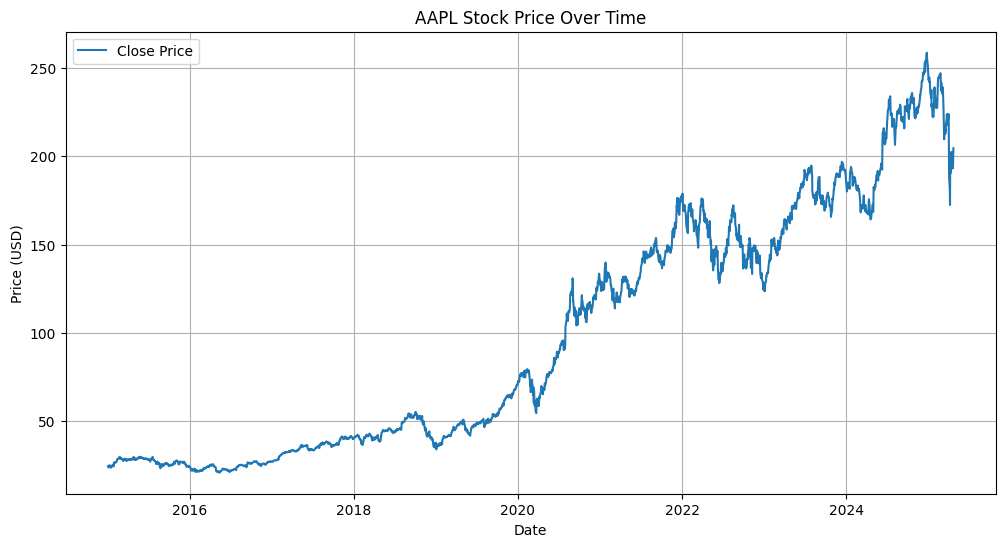

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


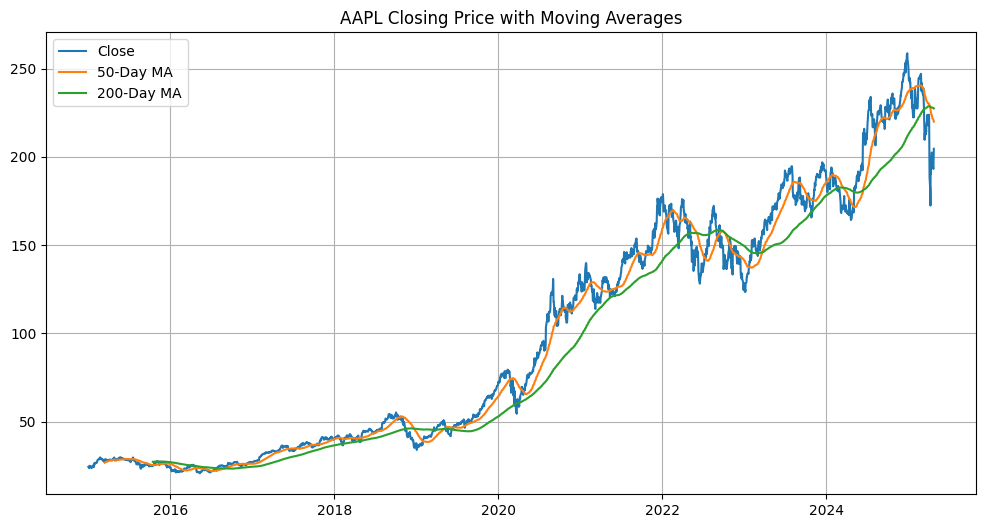

In [24]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA50'], label='50-Day MA')
plt.plot(df['MA200'], label='200-Day MA')
plt.title('AAPL Closing Price with Moving Averages')
plt.legend()
plt.grid(True)
plt.show()


TypeError: only length-1 arrays can be converted to Python scalars

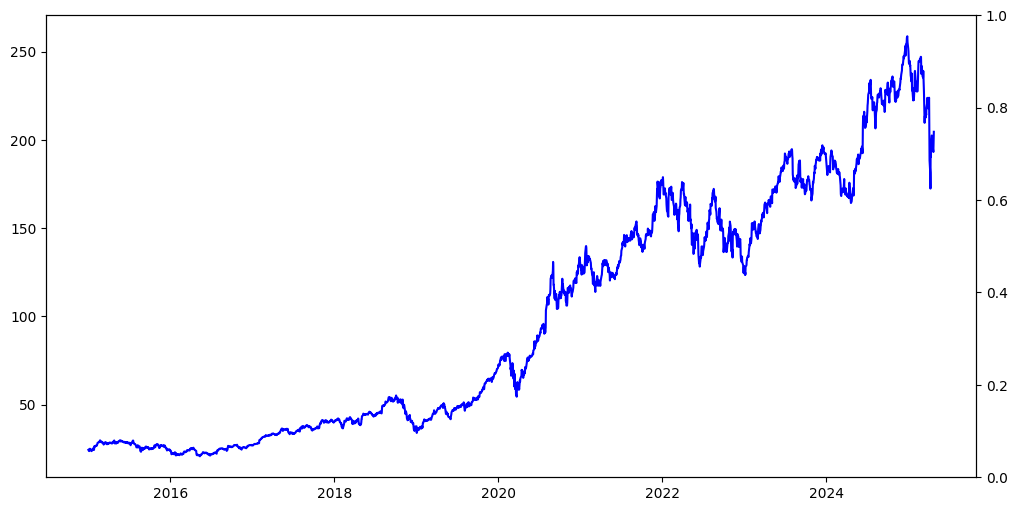

In [26]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df['Close'], color='blue')
ax2 = ax1.twinx()
# Convert the index to numerical values using pandas' to_numeric and matplotlib's date2num:
ax2.bar(pd.to_numeric(df.index).to_numpy(), df['Volume'], color='gray', alpha=0.3)
ax1.set_title('AAPL Closing Price & Volume')
ax1.set_ylabel('Price')
ax2.set_ylabel('Volume')
plt.grid(True)
plt.show()

In [32]:
# Create additional features
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

# Final feature set
features = df[['Close', 'HL_PCT', 'PCT_change', 'Volume']]

# Predict Close price 1 day into the future
forecast_out = 1
features['Target'] = features['Close'].shift(-forecast_out)
features.dropna(inplace=True)


<ipython-input-32-53bbaf66d30d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Target'] = features['Close'].shift(-forecast_out)
<ipython-input-32-53bbaf66d30d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(inplace=True)


In [33]:
X = features.drop('Target', axis=1).values
y = features['Target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


<ipython-input-33-1c1b046c5dc4>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = features.drop('Target', axis=1).values


In [38]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "SVR (RBF Kernel)": SVR(kernel='rbf')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name} - R2 Score: {r2_score(y_test, preds):.4f} | RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")


Linear Regression - R2 Score: 0.9833 | RMSE: 3.3424
Random Forest - R2 Score: -0.8433 | RMSE: 35.1281
SVR (RBF Kernel) - R2 Score: -20.4306 | RMSE: 119.7765


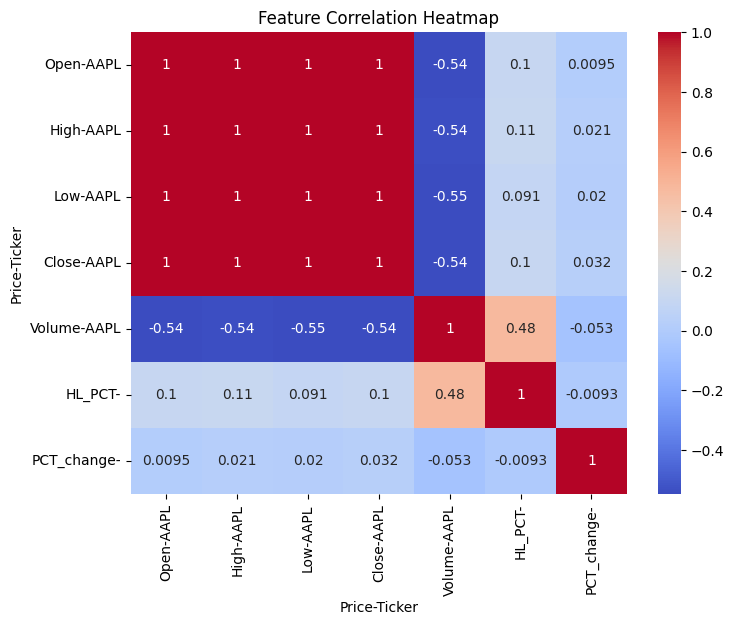

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


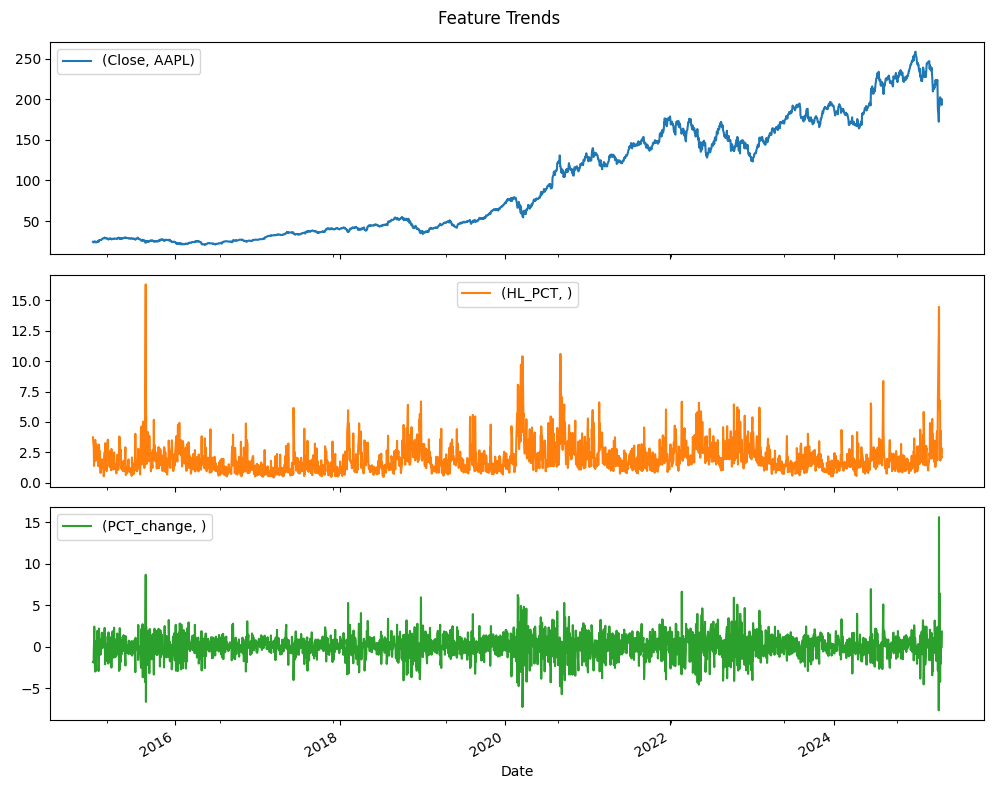

In [40]:
df[['Close', 'HL_PCT', 'PCT_change']].plot(subplots=True, figsize=(10, 8), title="Feature Trends")
plt.tight_layout()
plt.show()


#Deep Learning

In [41]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# Create sequences
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_lstm, y_lstm = create_sequences(scaled_data, time_step)

X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

train_size = int(len(X_lstm) * 0.8)
X_train_lstm = X_lstm[:train_size]
y_train_lstm = y_lstm[:train_size]
X_test_lstm = X_lstm[train_size:]
y_test_lstm = y_lstm[train_size:]


In [42]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0145
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4043e-04
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5684e-04
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9371e-04
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4314e-04
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8504e-04
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2510e-04
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4894e-04
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5089e-04
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2427e-04


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


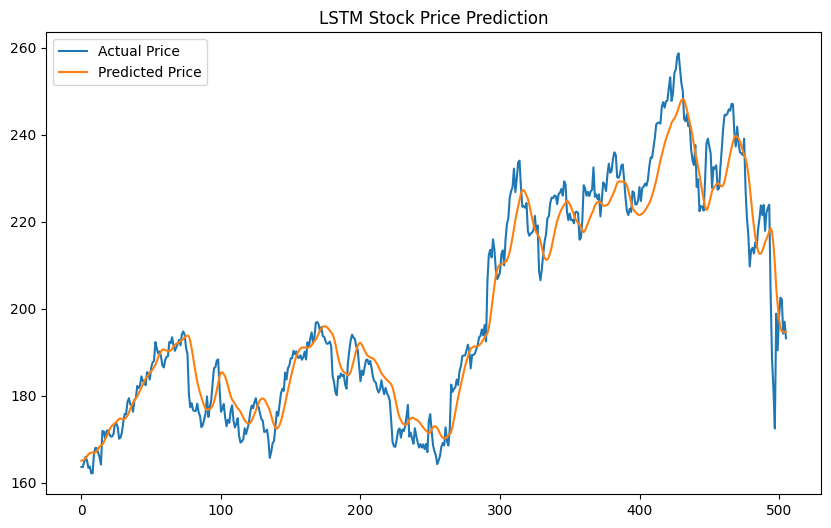

In [43]:
predicted_stock_price = model.predict(X_test_lstm)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
real_stock_price = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

plt.figure(figsize=(10,6))
plt.plot(real_stock_price, label='Actual Price')
plt.plot(predicted_stock_price, label='Predicted Price')
plt.title('LSTM Stock Price Prediction')
plt.legend()
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0286
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2434e-04
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1550e-04
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0199e-04
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1910e-04
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6393e-05
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0348e-04
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.9625e-05
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5778e-05
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2784e-05
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


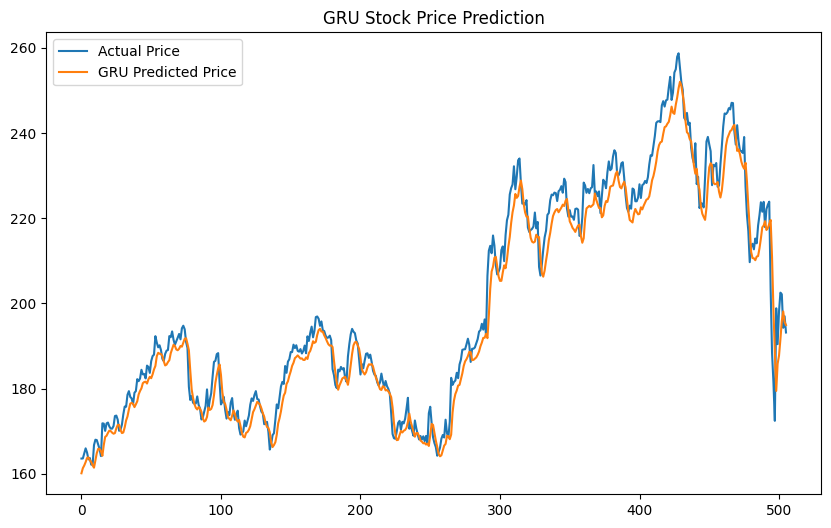

In [44]:
from keras.layers import GRU

# Build GRU Model
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
gru_model.add(GRU(50))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train GRU
gru_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

# Predict with GRU
predicted_gru = gru_model.predict(X_test_lstm)
predicted_gru = scaler.inverse_transform(predicted_gru.reshape(-1, 1))

# Plot
plt.figure(figsize=(10,6))
plt.plot(real_stock_price, label='Actual Price')
plt.plot(predicted_gru, label='GRU Predicted Price')
plt.title('GRU Stock Price Prediction')
plt.legend()
plt.show()


In [45]:
results_df = pd.DataFrame({
    'Actual Price': real_stock_price.flatten(),
    'LSTM Prediction': predicted_stock_price.flatten(),
    'GRU Prediction': predicted_gru.flatten()
})

# Export to CSV
results_df.to_csv("stock_predictions.csv", index=False)

# Export to Excel
results_df.to_excel("stock_predictions.xlsx", index=False)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

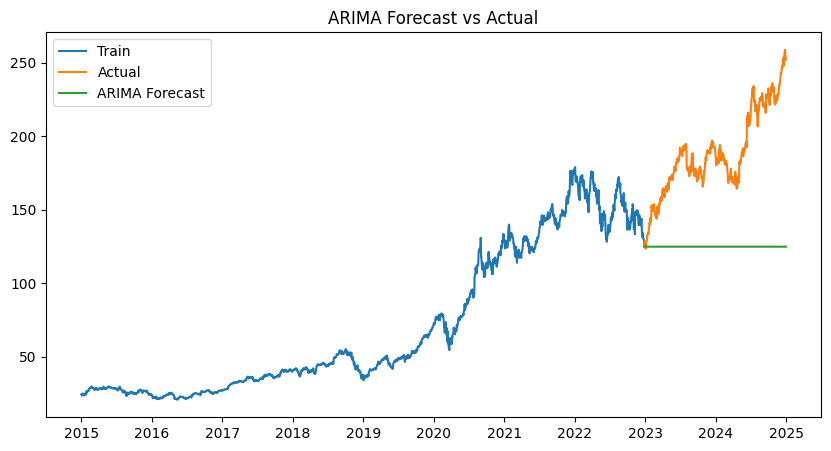

ARIMA RMSE: 69.7081


In [55]:
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

plt.figure(figsize=(10,5))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(forecast.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"ARIMA RMSE: {rmse:.4f}")


In [56]:
model_choice = st.selectbox("Choose Model", ["GRU", "ARIMA"])

2025-04-24 05:02:08.398 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 05:02:08.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 05:02:08.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 05:02:08.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 05:02:08.402 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 05:02:08.403 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [57]:
if model_choice == "GRU":
    # [Use your GRU code here]
    ...
elif model_choice == "ARIMA":
    st.write("### Running ARIMA...")
    from statsmodels.tsa.arima.model import ARIMA
    close_data = df[['Close']].dropna()

    train_size = int(len(close_data) * 0.8)
    train, test = close_data[:train_size], close_data[train_size:]

    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    forecast.index = test.index

    # Plot
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(train.index, train['Close'], label='Train')
    ax.plot(test.index, test['Close'], label='Actual')
    ax.plot(forecast.index, forecast, label='ARIMA Forecast')
    ax.legend()
    st.pyplot(fig)

    # Export CSV
    arima_df = pd.DataFrame({
        'Actual': test['Close'].values,
        'ARIMA Forecast': forecast.values
    }, index=test.index)

    st.download_button("Download ARIMA Results", arima_df.to_csv(index=True), "arima_predictions.csv")


In [46]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 135.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [100]:
import streamlit as st
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

st.title("📊 Stock Price Prediction: ARIMA & GRU")

# Input from user
ticker = st.text_input("Enter Stock Ticker (e.g., AAPL, MSFT, TSLA):", "AAPL")
start_date = st.date_input("Start Date", pd.to_datetime("2015-01-01"))
end_date = st.date_input("End Date", pd.to_datetime("2023-12-31"))

if st.button("Run Prediction"):
    df = yf.download(ticker, start=start_date, end=end_date)
    st.write("Raw Data", df.tail())

    # Plot original prices
    st.subheader("📈 Closing Price")
    st.line_chart(df["Close"])

    ### ARIMA Model
    st.subheader("🔮 ARIMA Prediction")
    try:
        arima_model = ARIMA(df['Close'], order=(5,1,0))
        arima_result = arima_model.fit()
        arima_forecast = arima_result.forecast(steps=30)
        st.line_chart(arima_forecast)
    except:
        st.warning("ARIMA model failed. Try a longer data range.")

    ### GRU Model
    st.subheader("🧠 GRU Forecast")

    data = df[['Close']]
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    time_step = 60
    for i in range(time_step, len(data_scaled)):
        X.append(data_scaled[i-time_step:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32, verbose=0)

    # Predict next 30 days
    input_data = data_scaled[-time_step:]
    predictions = []
    for _ in range(30):
        pred_input = np.reshape(input_data, (1, time_step, 1))
        pred = model.predict(pred_input, verbose=0)
        predictions.append(pred[0, 0])
        input_data = np.append(input_data[1:], pred[0, 0])

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
    future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=30)
    prediction_df = pd.DataFrame({'Date': future_dates, 'GRU_Prediction': predictions.flatten()})
    prediction_df.set_index("Date", inplace=True)
    st.line_chart(prediction_df)

    # Download predicted data
    csv = prediction_df.to_csv()
    st.download_button(label="📥 Download GRU Predictions", data=csv, file_name='gru_forecast.csv')

2025-04-24 06:10:35.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:10:35.049 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:10:35.049 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:10:35.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:10:35.051 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:10:35.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:10:35.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:10:35.053 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [101]:
import inspect # Import the inspect module

with open('app.py', 'w') as f:
    # Get the source code of the app function and write it to the file
    app_code = inspect.getsource(app)
    f.write(app_code)

In [105]:
from google.colab import files
files.download("app.py")
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [106]:
!python -m venv env
!source env/bin/activate  # On Windows: env\Scripts\activate

Error: Command '['/content/Time-forcasting/env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: env/bin/activate: No such file or directory


In [107]:
!pip install -r requirements.txt
# streamlit==1.32.0
# yfinance==0.2.36
# pandas==1.5.3
# numpy==1.24.3
# scikit-learn==1.2.2
# matplotlib==3.7.1
# keras==2.12.0
# tensorflow==2.12.0
# statsmodels==0.13.5


In [108]:
import streamlit as st
import yfinance as yf
import pandas as pd

st.title("📈 Simple Stock Price Viewer")

ticker = st.text_input("Enter stock ticker:", "AAPL")
start_date = st.date_input("Start date", pd.to_datetime("2020-01-01"))
end_date = st.date_input("End date", pd.to_datetime("2024-01-01"))

if st.button("Fetch Data"):
    data = yf.download(ticker, start=start_date, end=end_date)
    st.line_chart(data['Close'])
    st.write(data.tail())


2025-04-24 06:12:30.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:12:30.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:12:30.705 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:12:30.706 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:12:30.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:12:30.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:12:30.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 06:12:30.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.13.188.33:8501

